<a href="https://colab.research.google.com/github/jfvandem/dev_test_days/blob/master/intro_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dev test days 2019 - Meylan

basé sur https://www.kaggle.com/c/ashrae-energy-prediction/data

# Clone github

In [10]:
!git clone https://github.com/jfvandem/dev_test_days

fatal: destination path 'dev_test_days' already exists and is not an empty directory.


In [3]:
!pip3 install tensorflow==2.0.0
!pip3 install tqdm -U

     |████████████████████████████████| 86.3MB 26kB/s 
     |████████████████████████████████| 450kB 30.1MB/s 
     |████████████████████████████████| 3.8MB 31.2MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

     |████████████████████████████████| 61kB 1.8MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


# Import

In [0]:
import gc
import glob
import io
import itertools
import joblib
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import tensorflow as tf
import time
import warnings
import zipfile

from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
from math import sqrt
from matplotlib.collections import PatchCollection
from nltk.tokenize import word_tokenize
from os import path

from scipy import stats
from scipy.stats import skew

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers

In [5]:
print(tf.__version__)

2.0.0


# Chargement des données

In [6]:
!ls dev_test_days

dataset  intro_deep_learning.ipynb  README.md


In [0]:
data_dir='dev_test_days/dataset/'

In [8]:
train_df = pd.read_pickle(data_dir+'train_full_df.pkl.zip',compression='zip')
train_df.shape
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,meter_reading_log
0,0,0,2016-01-01,0.0,0,0,8.913550,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,9.0,0.0,0.0
4,4,0,2016-01-01,0.0,0,0,11.666565,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,42.0,0.0,0.0
5,5,0,2016-01-01,0.0,0,0,8.987197,2000.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,17.0,0.0,0.0
9,9,0,2016-01-01,0.0,0,6,10.203592,2010.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,7.0,0.0,0.0
10,10,0,2016-01-01,0.0,0,1,12.823345,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,26.0,0.0,0.0


In [14]:
le=joblib.load(data_dir+'label_encoder.pkl')

fatal: not a git repository (or any of the parent directories): .git


FileNotFoundError: ignored

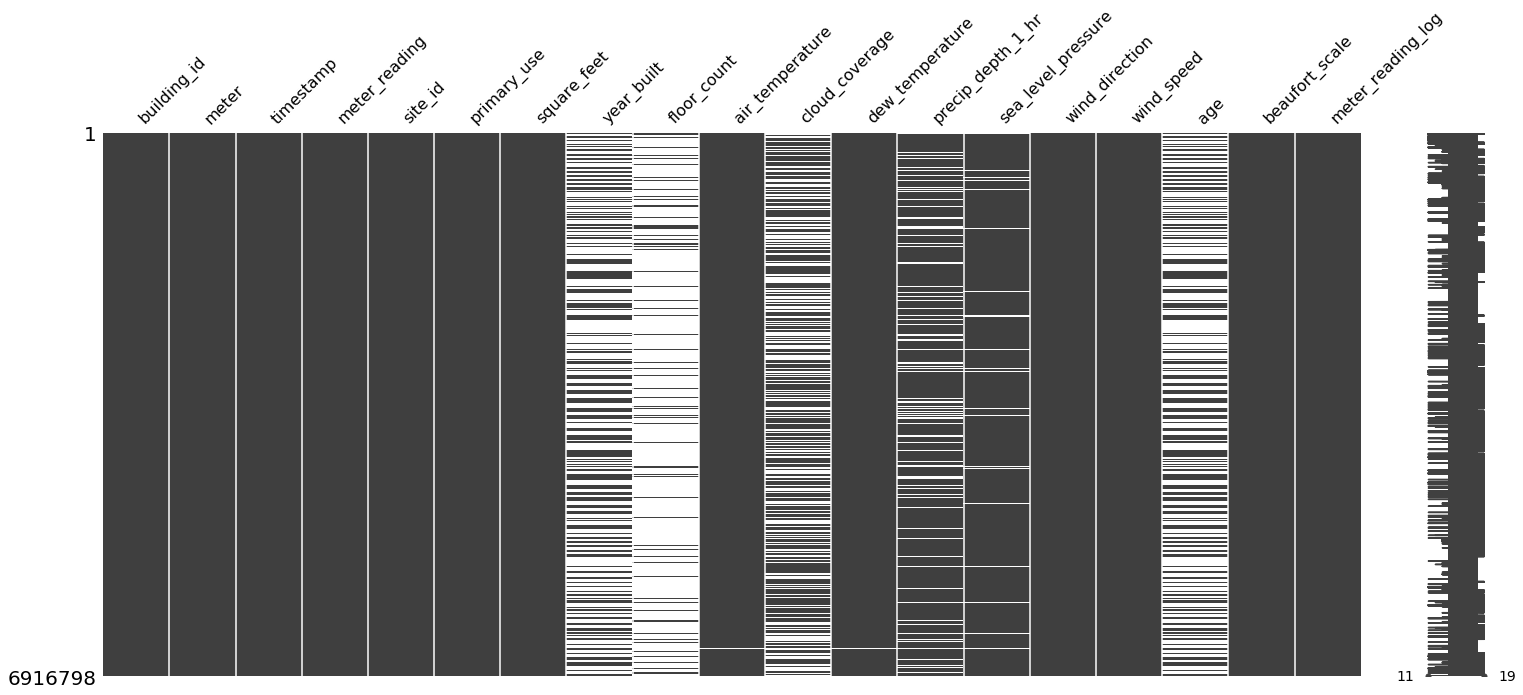

In [9]:
msno.matrix(train_df)

https://www.tensorflow.org/tutorials/keras/regression
https://www.tensorflow.org/tutorials/structured_data/time_series
https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series


In [0]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


In [0]:
model.summary()

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)


In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


In [0]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
